In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy

import os

### Get and explore data
Dataset - https://www.kaggle.com/grouplens/movielens-20m-dataset

In [2]:
DATA_PATH = "../data/100K"
df = pd.read_csv(os.path.join(DATA_PATH, 'rating.csv'))
movies_df = pd.read_csv(os.path.join(DATA_PATH, 'movie.csv'))
df.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


In [3]:
users = df['userId'].unique() 
movies = df['movieId'].unique() 
print("Number of users", len(users))
print("Number of movies", len(movies))
print(df.head())

Number of users 668
Number of movies 10325
   userId  movieId  rating   timestamp
0       1       16     4.0  1217897793
1       1       24     1.5  1217895807
2       1       32     4.0  1217896246
3       1       47     4.0  1217896556
4       1       50     4.0  1217896523


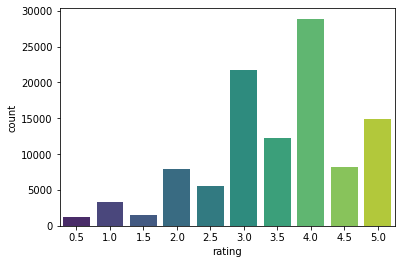

In [4]:
axes = sns.countplot(x=df['rating'], data=df, palette="viridis")

In [5]:
mean_rating = df['rating'].mean()
mean_rating

3.5168503593161127

In [6]:
df.movieId

0             16
1             24
2             32
3             47
4             50
           ...  
105334    142488
105335    142507
105336    143385
105337    144976
105338    148626
Name: movieId, Length: 105339, dtype: int64

### Train and Test split

In [7]:
def user_based_train_test_split(df, test_percent):
    """
    Split dataset based on users. The latest rating data (based on timestamp) goes to test
    
    Inspired by https://towardsdatascience.com/beginners-guide-to-creating-an-svd-recommender-system-1fd7326d1f65
    """
    train = pd.DataFrame(columns=df.columns)
    test = pd.DataFrame(columns=df.columns)

    test_percent_fractions = test_percent / 100

    for x in users:
        temp = df[df['userId'] == x]
        n = len(temp)
        test_size = int(test_percent_fractions*n)

        temp = temp.sort_values('timestamp').reset_index()
        temp.drop('index', axis=1, inplace=True)
            
        dummy_train = temp.loc[: n-2-test_size]
        dummy_test = temp.loc[n-1-test_size :]

        train = pd.concat([train, dummy_train])    
        test = pd.concat([test, dummy_test])
    return train, test


train, test = user_based_train_test_split(df, test_percent=20)

### Create Utility Matrix

The create_X() function outputs a sparse matrix X with four mapper dictionaries:

user_mapper: maps user id to user index
item_mapper: maps movie id to movie index
user_inv_mapper: maps user index to user id
item_inv_mapper: maps movie index to movie id
We need these dictionaries because they map which row/column of the utility matrix corresponds to which user/movie id.

Our X (user-item) matrix is a scipy.sparse.csr_matrix which stores the data sparsely.

In [8]:
from scipy.sparse import csr_matrix

def create_utility_matrix(df):
    """
    Function outputs a sparse matrix with four mapper dictionaries:

    user_mapper: maps user id to user index
    item_mapper: maps item id to item index
    user_inv_mapper: maps user index to user id
    item_inv_mapper: maps item index to item id

    Inspired by https://www.jillcates.com/pydata-workshop/html/tutorial.html
    """
    num_users = len(df['userId'].unique())
    num_movies = len(df['movieId'].unique())
      
    # Map IDs to indices
    user_mapper = dict(zip(np.unique(df["userId"]), list(range(num_users))))
    item_mapper = dict(zip(np.unique(df["movieId"]), list(range(num_movies))))
      
    # Map indices to IDs
    user_inverse_mapper = dict(zip(list(range(num_users)), np.unique(df["userId"])))
    item_inverse_mapper = dict(zip(list(range(num_movies)), np.unique(df["movieId"])))
      
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [item_mapper[i] for i in df['movieId']]
  
    X = csr_matrix((df["rating"].to_list(), (user_index, item_index)), shape=(num_users, num_movies))
          
    return X, user_mapper, item_mapper, user_inverse_mapper, item_inverse_mapper
  
utility_matrix, user_mapper, item_mapper, user_inverse_mapper, item_inverse_mapper = create_utility_matrix(train)

### Item-item Recommendations with k-Nearest Neighbors

Prediction for KNN algorithm (item based)
$$
\hat{r}_{ui} = \frac{\sum_{j \subseteq N_{u}^{k}(i)} sim(i,j) \cdot r_{uj}}{\sum_{j \subseteq N_{u}^{k}(i)} sim(i,j)}
$$

where 
 - $N_{i}^{k}(i)$ is a neighborhood of item $i$ of size $k$
 - $sim(i,j)$ similarity between chosen item and item from neighborhood
 - $r_{ui}$ rating that user u gave to item i

In [9]:
from sklearn.neighbors import NearestNeighbors

def get_average_rating(utility_matrix, item_idx):
    """
    Calculate average rating based on existing ratings.

    Zero values are skipped

    Input:
        utility_matrix - sparse numpy matrix. Format: items x users
        movie_idx - internal movie index
    
    Output:
        average rating
    """
    all_movie_ratings = utility_matrix[item_idx, :]
    average_rating = all_movie_ratings.sum() / all_movie_ratings.count_nonzero()
    return average_rating

class KNN:
    """
    K nearest neighbors recommendations.
    
    Inspired by https://www.jillcates.com/pydata-workshop/html/tutorial.html
    """
    def __init__(self) -> None:
        pass

    def train(self, X, item_mapper, item_inv_mapper, user_mapper, k, metric='cosine') -> None:
        self.k = k
        self.X = X.copy().T
        self.item_mapper = item_mapper
        self.item_inv_mapper = item_inv_mapper
        self.user_mapper = user_mapper
        self.kNN = NearestNeighbors(n_neighbors=self.k+1, algorithm="brute", metric=metric)
        self.kNN.fit(self.X)

    def _item_id_2_internal_idx(self, item_id: int):
        item_idx = self.item_mapper[item_id]
        return item_idx

    def _internal_idx_2_item_id(self, idx: int):
        item_id = self.item_inv_mapper[idx]
        return item_id

    def _user_id_2_internal_idx(self, user_id: int):
        user_idx = self.user_mapper[user_id]
        return user_idx

    def _get_neighbors(self, item_idx: int) -> np.array:
        """
        Return k neighbors for item with internal index item_idx

        Input:
            item_idx - internal item index
        Returns:
            distances - list of distances form item to other items
            neighbor_idxs - list of internal idxs
        """
        item_vec = self.X[item_idx]
        
        if isinstance(item_vec, (np.ndarray)):
            item_vec = item_vec.reshape(1,-1)
        
        distances_all, neighbor_idxs_all = self.kNN.kneighbors(item_vec, return_distance=True)
        # The first neighbor is an item itself
        distances = distances_all[:,1:]
        neighbor_idxs = neighbor_idxs_all[:,1:]
        return distances[0], neighbor_idxs[0]
    
    def _get_rating(self, user_idx, item_idx) -> float:
        rating = self.X[item_idx, user_idx]
        # TODO: floating point comparison. Rewrite condition
        if rating != 0.0:
            return rating
        else:
            return get_average_rating(self.X, item_idx)

    def predict_item_based(self, user_id, item_id) -> float:
        user_idx = self._user_id_2_internal_idx(user_id)
        item_idx = self._item_id_2_internal_idx(item_id)
        distances, similar_item_idxs = self._get_neighbors(item_idx)

        # TODO: How to implement it better?
        def rating_for_current_user(item_idx):
            return self._get_rating(user_idx=user_idx, item_idx=item_idx)
        rating_for_current_user_vectorized = np.vectorize(rating_for_current_user)
        ratings = rating_for_current_user_vectorized(similar_item_idxs)
        
        predicted_rating = (distances * ratings).sum()/distances.sum()
        return predicted_rating

    def get_similar_items(self, item_id):
        item_idx = self._item_id_2_internal_idx(item_id)
        _, similar_item_idxs =  self._get_neighbors(item_idx)
        
        transformer_vectorized = np.vectorize(self._internal_idx_2_item_id)
        similar_item_ids = transformer_vectorized(similar_item_idxs)
        return similar_item_ids


knn = KNN()
knn.train(X=utility_matrix, item_mapper=item_mapper, item_inv_mapper=item_inverse_mapper, user_mapper=user_mapper, k=15)

rating = knn.predict_item_based(9, 1275)
print(rating)

3.524050461355738


In [10]:
def get_movie_title(df, id):
    return df.loc[df.movieId == id, 'title'].item()

movie_id = 9
similar_movies = knn.get_similar_items(item_id=movie_id)

print(f"Original movie: {get_movie_title(movies_df, movie_id)}")
print(f"Recomendations: ")
for n in similar_movies:
    print(f"    {get_movie_title(movies_df, n)}")

Original movie: Sudden Death (1995)
Recomendations: 
    Eye for an Eye (1996)
    Quest, The (1996)
    Substitute, The (1996)
    Mr. Wrong (1996)
    Pallbearer, The (1996)
    Great White Hype, The (1996)
    Rumble in the Bronx (Hont faan kui) (1995)
    Executive Decision (1996)
    Fear (1996)
    Mulholland Falls (1996)
    Phantom, The (1996)
    It's My Party (1996)
    Santa with Muscles (1996)
    Switchblade Sisters (1975)
    Denise Calls Up (1995)


### SVD full matrix computation (np.linalg.svd)


P - user-feature matrix. Dimension: number of users by number of features.
S - singular values
Q - movie-feature matrix. Dimension: number of features by number of movies.

Prediction rule
$$
\widetilde{r_{ui}} = u + \sum_{f}{p_{userfeature} \cdot \sigma_{feature} \cdot q_{itemfeature}}
$$
where $u$ - item mean

In [11]:
def svd(train, num_features):
    """
    Calculate full SVD and take only main num_features features
    Decompose a matrix into arrays of feature vectors corresponding to each row and each column

    Inspired by https://towardsdatascience.com/beginners-guide-to-creating-an-svd-recommender-system-1fd7326d1f65
    """
    utilMat = train.toarray()
    
    # Mask NaN cells
    mask = np.isnan(utilMat)
    masked_arr = np.ma.masked_array(utilMat, mask)
    item_means = np.mean(masked_arr, axis=0)
    
    # Replace NaN with averate rating for every item
    utilMat = masked_arr.filled(item_means)
    item_average = np.tile(item_means, (utilMat.shape[0], 1))
    
    # NaN will be zero this way
    utilMat = utilMat - item_average
    
    U, S, V = np.linalg.svd(utilMat, full_matrices=False)
    S = S[0:num_features]
    U = U[:,0:num_features]
    V = V[0:num_features,:]
    return U, S, V, item_average

num_features = 15
U, S, V, item_average = svd(utility_matrix, num_features)

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from collections import defaultdict

item_mapper_default = defaultdict(lambda: -1, item_mapper)
user_mapper_default = defaultdict(lambda: -1, user_mapper)

def predict_pair(user_id, item_id, P, S, Q, item_mean):
    item = item_mapper_default[item_id]
    user = user_mapper_default[user_id]
    if item == -1 or user == -1:
        return None
    return (P[user, :].dot(Q[:, item]) * S).sum() + item_mean[0,item]

def svd_predict(data, P, S, Q, item_mean):
    return np.array([
        predict_pair(u_id, i_id, P, S, Q, item_mean) # TODO: move  P, S, Q to internal data
        for u_id, i_id in zip(data['userId'], data['movieId'])])
    
    
pred = svd_predict(test, U, S, V, item_average)
pred[:20]

array([-0.10044425798463363, 12.409202650143111, 2.587578588975016,
       7.675745327280214, 0.05949469520712025, 7.14972109538222,
       0.498161595975506, 8.63563941243655, 1.5979556197452125,
       2.5732028747264293, 3.854769500615833, 1.594939569283682,
       -5.806061611041498, 2.1860062466371453, 0.3674602102848846,
       -4.584481313213351, -2.996384842585737, 1.6120270900715994,
       -2.4955645726444597, -0.7062459206522437], dtype=object)

In [13]:
def print_prediction_table(prediction, test, num_predictions=10):
    # TODO: copypaste
    test_cleaned = test.copy()
    not_present_in_train = np.where(prediction == None)[0]
    test_cleaned.reset_index(drop=True, inplace=True)
    valid_test = test_cleaned.drop(not_present_in_train)
    valid_prediction = prediction[prediction != None]
    
    # Clip predictions
    MIN_RATING = 0
    MAX_RATING = 5
    valid_prediction = np.clip(valid_prediction, MIN_RATING, MAX_RATING)

    print("Prediction examples")
    print("Movie | True rating | Predicted rating")
    random_idxs = np.random.randint(0, valid_test.shape[0], min(num_predictions, valid_test.shape[0]))
    for idx in random_idxs:
        # TODO: some bug in indexing
        title = get_movie_title(movies_df, valid_test.loc[idx, 'movieId'])
        true_rating = valid_test.loc[idx, 'rating']
        predicted_rating = valid_prediction[idx]
        print(f"{title} | {true_rating} | {predicted_rating}")

print_prediction_table(pred, test)


Prediction examples
Movie | True rating | Predicted rating
All the King's Men (1949) | 4.0 | 2.2957427382735895
21 (2008) | 3.0 | 2.292750928236001
Jay and Silent Bob Strike Back (2001) | 2.0 | 0
Insidious (2010) | 4.5 | 2.3103012296305687
Zodiac (2007) | 4.5 | 0.7170372903781822
Gosford Park (2001) | 4.0 | 5
Sunshine (2007) | 2.0 | 5
Time Machine, The (2002) | 0.5 | 2.966921571394393
Legends of the Fall (1994) | 4.0 | 4.592901540450845
American Gangster (2007) | 3.5 | 5


In [14]:
def test_svd_prediction(test, prediction):
    # Drop movies that are not present in train set - we cannot predict anything for them
    test_rating = test['rating'].copy()
    not_present_in_train = np.where(prediction == None)[0]
    test_rating.reset_index(drop=True, inplace=True)
    valid_test_rating = test_rating.drop(not_present_in_train)
    valid_prediction = prediction[prediction != None]

    # Clip predictions
    MIN_RATING = 0
    MAX_RATING = 5
    valid_prediction = np.clip(valid_prediction, MIN_RATING, MAX_RATING)
    
    mae = mean_absolute_error(valid_test_rating, valid_prediction)
    rmse = mean_squared_error(valid_test_rating, valid_prediction)
    print(f'Test MAE: {mae:.2f}')
    print(f'Test RMSE: {rmse:.2f}')

test_svd_prediction(test, prediction=pred)


Test MAE: 2.21
Test RMSE: 6.83


### SVD short matrix computation (scipy.sparse.linalg.svds)


In [15]:
def sparse_svd(utility_matrix, num_features):
    """
    Calculate SVD on a sparse matrix.

    Input:
        utility_matrix - sparse utility matrix, users x items
        num_features   - number of latent features
    Output:
        P              - user matrix, shape is num_users x num_features
        S              - singular values, num_features
        Q              - item matrix, shape is num_users x num_features
        item_average   - average item rating (including only existing ratings)
    """
    item_average = utility_matrix.sum(axis=0)

    for idx in range(utility_matrix.shape[1]):
        item_average[0,idx] /= utility_matrix[:,idx].count_nonzero()
    
    normalized_utility_matrix = utility_matrix - item_average
    P, S, Q = scipy.sparse.linalg.svds(normalized_utility_matrix, num_features)
    return P, S, Q, item_average
    
P, S, Q, item_average = sparse_svd(utility_matrix, num_features=15)

pred = svd_predict(test, U, S, V, item_average)
test_svd_prediction(test, prediction=pred)

Test MAE: 1.98
Test RMSE: 5.72


In [16]:
def test_svd_prediction(test, prediction):
    # Drop movies that are not present in train set - we cannot predict anything for them
    test_rating = test['rating']
    not_present_in_train = np.where(prediction == None)[0]
    test_rating.reset_index(drop=True, inplace=True)
    valid_test_rating = test_rating.drop(not_present_in_train)
    valid_prediction = prediction[prediction != None]

    # Clip predictions
    MIN_RATING = 0
    MAX_RATING = 5
    valid_prediction = np.clip(valid_prediction, MIN_RATING, MAX_RATING)
    
    mae = mean_absolute_error(valid_test_rating, valid_prediction)
    rmse = mean_squared_error(valid_test_rating, valid_prediction)
    print(f'Test MAE: {mae:.2f}')
    print(f'Test RMSE: {rmse:.2f}')

test_svd_prediction(test, prediction=pred)

Test MAE: 1.98
Test RMSE: 5.72


In [18]:
print_prediction_table(pred, test)

Prediction examples
Movie | True rating | Predicted rating
12 Rounds (2009) | 2.0 | 5
12 Years a Slave (2013) | 2.5 | 5
Thelma & Louise (1991) | 1.0 | 5
Despicable Me (2010) | 4.0 | 5
Léon: The Professional (a.k.a. The Professional) (Léon) (1994) | 4.5 | 5
K-19: The Widowmaker (2002) | 4.5 | 5
Wayne's World 2 (1993) | 2.0 | 3.6169762902310385
Lucy (2014) | 2.5 | 5
Back to the Future Part III (1990) | 4.0 | 0
Eve's Bayou (1997) | 5.0 | 5
